# Multi Stage Prediction 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [2]:
# Load Data

daily_data = pd.read_csv("daily_merged_data.csv")
monthly_data = pd.read_csv("merged_monthyl_data.csv")
yearly_data = pd.read_csv("merged_Yearly_data,csv")


In [3]:
# Convert datetime columns
daily_data["datetime"] = pd.to_datetime(daily_data["datetime"])

daily_data.set_index("datetime", inplace=True)

In [4]:
# Ensure numerical columns are correctly formatted
yearly_data["Population"] = yearly_data["Population"].str.replace(',', '').astype(float)

In [5]:
## Feature Engineering Function
def feature_importance_rfa(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances.sort_values(ascending=False, inplace=True)
    return feature_importances

In [6]:
# One-Hot Encode PriceComponents
yearly_data = pd.get_dummies(yearly_data, columns=["PriceComponents"], drop_first=True)

In [7]:
## Stage 1: Yearly Forecasting
yearly_features = yearly_data.drop(columns=["loadConsumption"])
yearly_target = "loadConsumption"
X_yearly = yearly_features
y_yearly = yearly_data[yearly_target]

# Compute feature importance
yearly_feature_importance = feature_importance_rfa(X_yearly, y_yearly)
selected_yearly_features = yearly_feature_importance.index[:5]
X_yearly = X_yearly[selected_yearly_features]

# Train Yearly Model
X_train_yearly, X_test_yearly, y_train_yearly, y_test_yearly = train_test_split(X_yearly, y_yearly, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_yearly)
X_test_scaled = scaler.transform(X_test_yearly)

model_yearly = RandomForestRegressor(n_estimators=100, random_state=42)
model_yearly.fit(X_train_scaled, y_train_yearly)
y_pred_yearly = model_yearly.predict(X_test_scaled)

# Store yearly predictions in monthly dataset
monthly_data["Predicted_Yearly_Load"] = np.repeat(model_yearly.predict(scaler.transform(X_yearly)), len(monthly_data) // len(yearly_data))[:len(monthly_data)]

# Evaluate
print("Yearly Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_yearly, y_pred_yearly)}, MSE: {mean_squared_error(y_test_yearly, y_pred_yearly)}, R^2: {r2_score(y_test_yearly, y_pred_yearly)}, MAPE: {np.mean(np.abs((y_test_yearly - y_pred_yearly) / y_test_yearly)) * 100}")


Yearly Model Performance:
MAE: 92145.41036500037, MSE: 11152118845.504124, R^2: 0.9992810399015079, MAPE: 0.08169781956624085


In [8]:
monthly_data.isna().sum()

Year                                                      0
Month                                                     0
Gross production (MWh)                                    0
Net production/Net production, total (MWh)                0
Net production/Nuclear energy (MWh)                       3
Net production/Fuels/Fuels, total (MWh)                   0
Net production/Fuels/Coal (MWh)                           0
Net production/Fuels/Petroleum products (MWh)             0
Net production/Fuels/Natural gas (MWh)                    0
Net production/Fuels/Biomass (MWh)                        0
Net production/Fuels/Other fuels (non-renewable) (MWh)    0
Net production/Hydro power (MWh)                          0
Net production/Wind energy/Wind energy, total (MWh)       0
Net production/Wind energy/Wind energy on shore (MWh)     0
Net production/Wind energy/Wind energy off shore (MWh)    0
Net production/Solar photovoltaic (MWh)                   0
Net production/Other sources (MWh)      

In [9]:
monthly_data.fillna(method="ffill", inplace=True)

C:\Users\mahmo\AppData\Local\Temp\ipykernel_4276\1658306591.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data.fillna(method="ffill", inplace=True)


In [10]:
## Stage 2: Monthly Breakdown
monthly_features = monthly_data.drop(columns=["loadConsumption"])
monthly_target = "loadConsumption"
X_monthly = monthly_features
y_monthly = monthly_data[monthly_target]

# Compute feature importance
monthly_feature_importance = feature_importance_rfa(X_monthly, y_monthly)
selected_monthly_features = list(monthly_feature_importance.index[:5]) + ["Predicted_Yearly_Load"]
X_monthly = X_monthly[selected_monthly_features]

# Train Monthly Model
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_monthly, y_monthly, test_size=0.2, random_state=42)
X_train_scaled_monthly = scaler.fit_transform(X_train_monthly)
X_test_scaled_monthly = scaler.transform(X_test_monthly)

model_monthly = RandomForestRegressor(n_estimators=100, random_state=42)
model_monthly.fit(X_train_scaled_monthly, y_train_monthly)
y_pred_monthly = model_monthly.predict(X_test_scaled_monthly)

# Store monthly predictions in daily dataset
# Expand monthly predictions to match daily data size
num_days_per_month = len(daily_data) // len(monthly_data)
predicted_monthly_load = np.repeat(model_monthly.predict(scaler.transform(X_monthly)), num_days_per_month)

# Handle potential size mismatch
if len(predicted_monthly_load) < len(daily_data):
    predicted_monthly_load = np.append(predicted_monthly_load, predicted_monthly_load[-1] * np.ones(len(daily_data) - len(predicted_monthly_load)))

daily_data["Predicted_Monthly_Load"] = predicted_monthly_load[:len(daily_data)]


# Evaluate
print("Monthly Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_monthly, y_pred_monthly)}, MSE: {mean_squared_error(y_test_monthly, y_pred_monthly)}, R^2: {r2_score(y_test_monthly, y_pred_monthly)}, MAPE: {np.mean(np.abs((y_test_monthly - y_pred_monthly) / y_test_monthly)) * 100}")






Monthly Model Performance:
MAE: 196088.10351124854, MSE: 60454531665.29464, R^2: 0.8692473799142865, MAPE: 2.1816473618357612


In [11]:
daily_data = pd.get_dummies(daily_data, columns=["day_of_week"], drop_first=True)

In [12]:
## Stage 3: Daily Forecasting
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5]) + ["Predicted_Monthly_Load"]
X_daily = X_daily[selected_daily_features]

# Train Daily Model
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)
X_train_scaled_daily = scaler.fit_transform(X_train_daily)
X_test_scaled_daily = scaler.transform(X_test_daily)

model_daily = RandomForestRegressor(n_estimators=100, random_state=42)
model_daily.fit(X_train_scaled_daily, y_train_daily)
y_pred_daily = model_daily.predict(X_test_scaled_daily)

# Evaluate
print("Daily Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_daily, y_pred_daily)}, MSE: {mean_squared_error(y_test_daily, y_pred_daily)}, R^2: {r2_score(y_test_daily, y_pred_daily)}, MAPE: {np.mean(np.abs((y_test_daily - y_pred_daily) / y_test_daily)) * 100}")

Daily Model Performance:
MAE: 7687.579140126818, MSE: 135089685.0667731, R^2: 0.8578477472699897, MAPE: 2.629288552402167


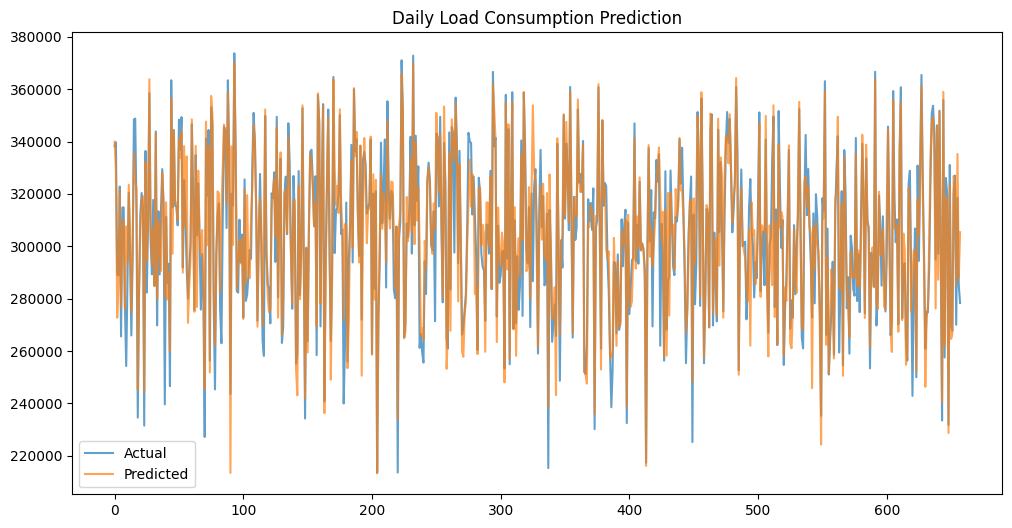

In [13]:
# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_daily.values, label="Actual", alpha=0.7)
plt.plot(y_pred_daily, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Daily Load Consumption Prediction")
plt.show()


In [14]:
## Stage 3: Future Daily Forecasting
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5]) + ["Predicted_Monthly_Load"]
X_daily = X_daily[selected_daily_features]

# Define prediction horizon (180-365 days into the future)
prediction_horizon = 180  # Change to 180 if needed
X_train_daily = X_daily.iloc[:-prediction_horizon]
y_train_daily = y_daily.iloc[:-prediction_horizon]
X_future = X_daily.iloc[-prediction_horizon:]

# Train Daily Model
scaler = StandardScaler()
X_train_scaled_daily = scaler.fit_transform(X_train_daily)
X_future_scaled = scaler.transform(X_future)

model_daily = RandomForestRegressor(n_estimators=100, random_state=42)
model_daily.fit(X_train_scaled_daily, y_train_daily)
y_future_pred = model_daily.predict(X_future_scaled)


Future Daily Model Performance:
Predictions for the next 180 days generated.


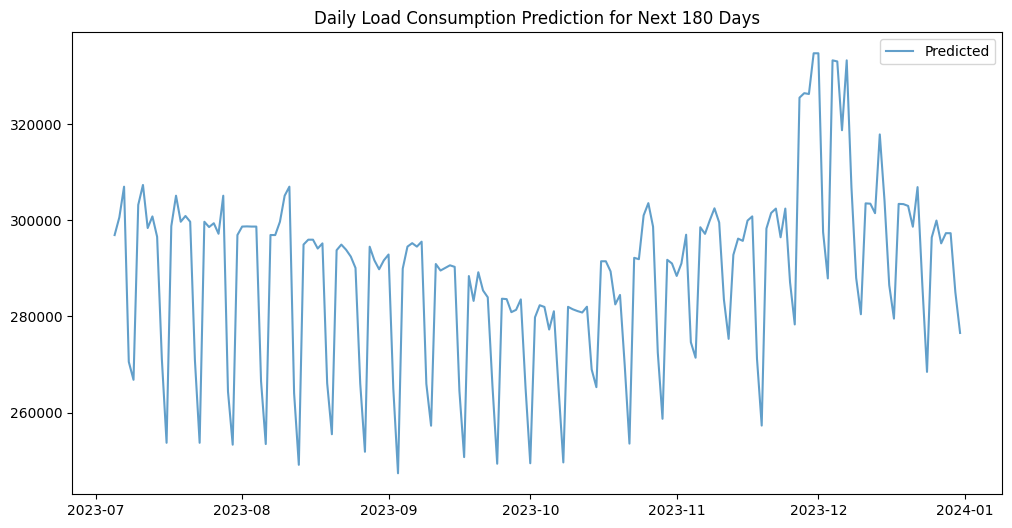

In [15]:
# Evaluate
print("Future Daily Model Performance:")
print(f"Predictions for the next {prediction_horizon} days generated.")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_daily.index[-prediction_horizon:], y_future_pred, label="Predicted", alpha=0.7)
plt.legend()
plt.title(f"Daily Load Consumption Prediction for Next {prediction_horizon} Days")
plt.show()


2019 Model Performance:
MAE: 15918.38882563601, MSE: 384567155.04042214, R^2: 0.5629308371185787, MAPE: 5.24114487374999
2023 Model Performance:
MAE: 14432.99382462326, MSE: 336910821.39781034, R^2: 0.5846105682429463, MAPE: 4.753518255119566


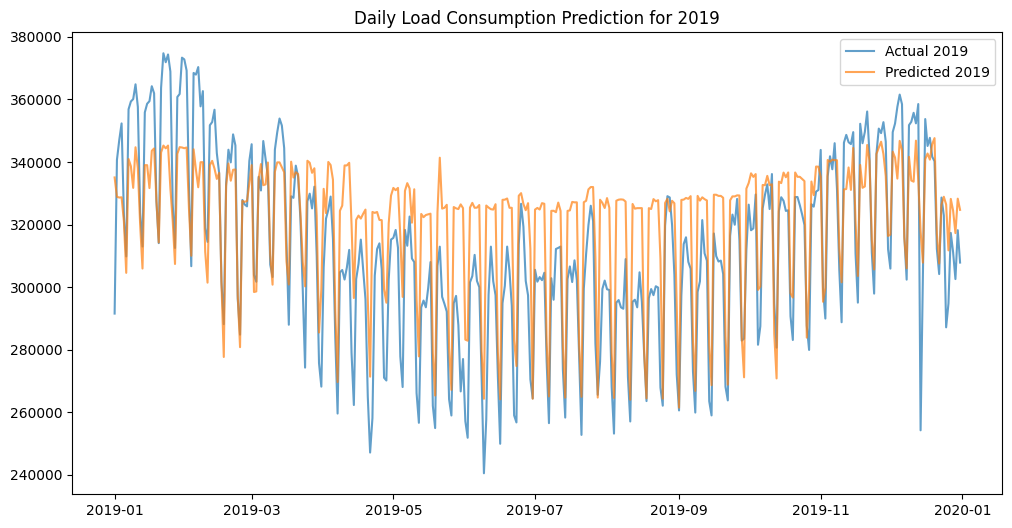

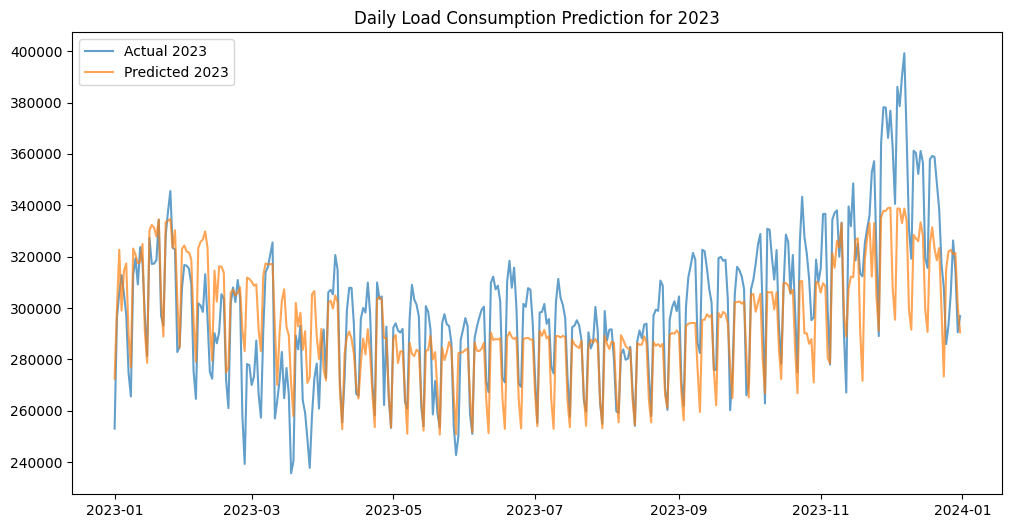

In [16]:
## Stage 3: Testing Performance on 2019 and 2023
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5]) + ["Predicted_Monthly_Load"]
X_daily = X_daily[selected_daily_features]

# Define 2019 and 2023 data
X_train_2019 = X_daily.loc["2018-01-01":"2018-12-31"]
y_train_2019 = y_daily.loc["2018-01-01":"2018-12-31"]
X_test_2019 = X_daily.loc["2019-01-01":"2019-12-31"]
y_test_2019 = y_daily.loc["2019-01-01":"2019-12-31"]

X_train_2022 = X_daily.loc["2021-01-01":"2021-12-31"]
y_train_2022 = y_daily.loc["2021-01-01":"2021-12-31"]
X_test_2023 = X_daily.loc["2023-01-01":"2023-12-31"]
y_test_2023 = y_daily.loc["2023-01-01":"2023-12-31"]

# Train Model on 2018 and Predict 2019
scaler = StandardScaler()
X_train_scaled_2019 = scaler.fit_transform(X_train_2019)
X_test_scaled_2019 = scaler.transform(X_test_2019)

model_2019 = RandomForestRegressor(n_estimators=100, random_state=42)
model_2019.fit(X_train_scaled_2019, y_train_2019)
y_pred_2019 = model_2019.predict(X_test_scaled_2019)

# Train Model on 2021 and Predict 2023
X_train_scaled_2022 = scaler.fit_transform(X_train_2022)
X_test_scaled_2023 = scaler.transform(X_test_2023)

model_2023 = RandomForestRegressor(n_estimators=100, random_state=42)
model_2023.fit(X_train_scaled_2022, y_train_2022)
y_pred_2023 = model_2023.predict(X_test_scaled_2023)

# Evaluate
print("2019 Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_2019, y_pred_2019)}, MSE: {mean_squared_error(y_test_2019, y_pred_2019)}, R^2: {r2_score(y_test_2019, y_pred_2019)}, MAPE: {np.mean(np.abs((y_test_2019 - y_pred_2019) / y_test_2019)) * 100}")

print("2023 Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_2023, y_pred_2023)}, MSE: {mean_squared_error(y_test_2023, y_pred_2023)}, R^2: {r2_score(y_test_2023, y_pred_2023)}, MAPE: {np.mean(np.abs((y_test_2023 - y_pred_2023) / y_test_2023)) * 100}")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_2019.index, y_test_2019, label="Actual 2019", alpha=0.7)
plt.plot(y_test_2019.index, y_pred_2019, label="Predicted 2019", alpha=0.7)
plt.legend()
plt.title("Daily Load Consumption Prediction for 2019")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_2023.index, y_test_2023, label="Actual 2023", alpha=0.7)
plt.plot(y_test_2023.index, y_pred_2023, label="Predicted 2023", alpha=0.7)
plt.legend()
plt.title("Daily Load Consumption Prediction for 2023")
plt.show()


2019 Ensemble Model Performance:
MAE: 18749.24125301696, MSE: 504514173.96120113, R^2: 0.42660837051501144, MAPE: 6.151543866633436
2023 Ensemble Model Performance:
MAE: 15660.182962551351, MSE: 401025459.11147076, R^2: 0.5055613325529471, MAPE: 5.139213434634714


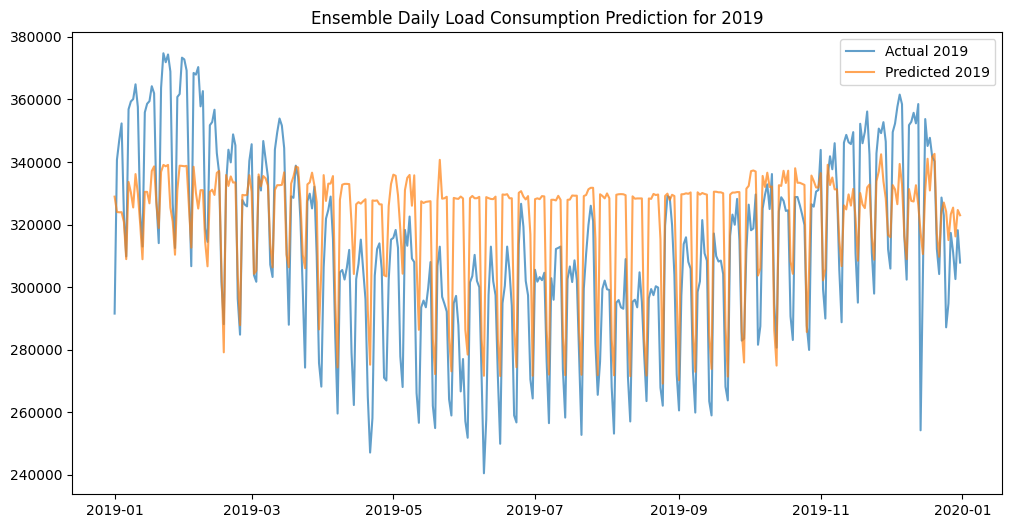

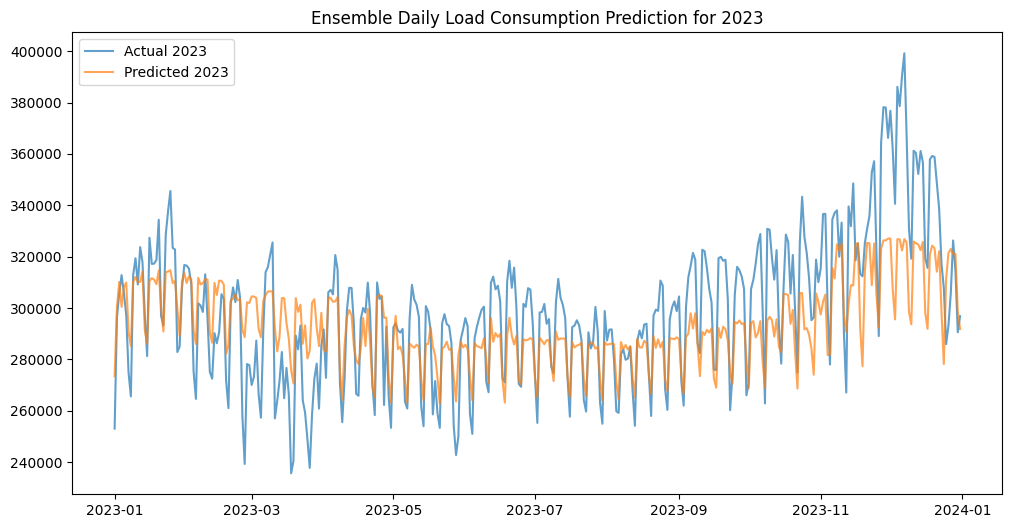

In [17]:
## Stage 3: Testing Performance on 2019 and 2023
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5]) + ["Predicted_Monthly_Load"]
X_daily = X_daily[selected_daily_features]

# Define 2019 and 2023 data
X_train_2019 = X_daily.loc["2018-01-01":"2018-12-31"]
y_train_2019 = y_daily.loc["2018-01-01":"2018-12-31"]
X_test_2019 = X_daily.loc["2019-01-01":"2019-12-31"]
y_test_2019 = y_daily.loc["2019-01-01":"2019-12-31"]

X_train_2022 = X_daily.loc["2021-01-01":"2021-12-31"]
y_train_2022 = y_daily.loc["2021-01-01":"2021-12-31"]
X_test_2023 = X_daily.loc["2023-01-01":"2023-12-31"]
y_test_2023 = y_daily.loc["2023-01-01":"2023-12-31"]

# Train Ensemble Model on 2018 and Predict 2019
scaler = StandardScaler()
X_train_scaled_2019 = scaler.fit_transform(X_train_2019)
X_test_scaled_2019 = scaler.transform(X_test_2019)

ensemble_model_2019 = VotingRegressor([
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=6))
])
ensemble_model_2019.fit(X_train_scaled_2019, y_train_2019)
y_pred_2019 = ensemble_model_2019.predict(X_test_scaled_2019)

# Train Ensemble Model on 2021 and Predict 2023
X_train_scaled_2022 = scaler.fit_transform(X_train_2022)
X_test_scaled_2023 = scaler.transform(X_test_2023)

ensemble_model_2023 = VotingRegressor([
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5))
])
ensemble_model_2023.fit(X_train_scaled_2022, y_train_2022)
y_pred_2023 = ensemble_model_2023.predict(X_test_scaled_2023)

# Evaluate
print("2019 Ensemble Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_2019, y_pred_2019)}, MSE: {mean_squared_error(y_test_2019, y_pred_2019)}, R^2: {r2_score(y_test_2019, y_pred_2019)}, MAPE: {np.mean(np.abs((y_test_2019 - y_pred_2019) / y_test_2019)) * 100}")

print("2023 Ensemble Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_2023, y_pred_2023)}, MSE: {mean_squared_error(y_test_2023, y_pred_2023)}, R^2: {r2_score(y_test_2023, y_pred_2023)}, MAPE: {np.mean(np.abs((y_test_2023 - y_pred_2023) / y_test_2023)) * 100}")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_2019.index, y_test_2019, label="Actual 2019", alpha=0.7)
plt.plot(y_test_2019.index, y_pred_2019, label="Predicted 2019", alpha=0.7)
plt.legend()
plt.title("Ensemble Daily Load Consumption Prediction for 2019")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_2023.index, y_test_2023, label="Actual 2023", alpha=0.7)
plt.plot(y_test_2023.index, y_pred_2023, label="Predicted 2023", alpha=0.7)
plt.legend()
plt.title("Ensemble Daily Load Consumption Prediction for 2023")
plt.show()


In [ ]:
# Define LSTM Data Preparation Function
def prepare_lstm_data(data, target_column, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i-lookback:i].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)
    
# Select Features and Target
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"

# Scale features
scaler_features = StandardScaler()
daily_features_scaled = scaler_features.fit_transform(daily_features)

# Scale target separately
scaler_target = StandardScaler()
daily_target_scaled = scaler_target.fit_transform(daily_data[["loadConsumption"]])

# Combine features and target into a DataFrame
daily_scaled_df = pd.DataFrame(daily_features_scaled, index=daily_data.index, columns=daily_features.columns)
daily_scaled_df["loadConsumption"] = daily_target_scaled  # Add target back

# Prepare LSTM Data
lookback = 30  # Use past 30 days to predict next day
X_lstm, y_lstm = prepare_lstm_data(daily_scaled_df, "loadConsumption", lookback)

# Split Data into Train and Test
split_index = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

# Define LSTM Model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, X_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile Model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train Model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test_lstm))

# Function for Multi-Step Forecasting
def multi_step_forecast(model, initial_input, days_ahead, scaler):
    forecast = []
    current_input = initial_input.copy()
    
    for _ in range(days_ahead):
        pred = model.predict(current_input.reshape(1, current_input.shape[0], current_input.shape[1]))
        forecast.append(pred[0][0])
        
        # Shift input window and add prediction
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, -1] = pred[0][0]  # Use the predicted value
    
    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Predict Next 180 Days Using Multi-Step Forecasting
initial_input = X_test_lstm[-1]  # Start from last known test sample
future_predictions = multi_step_forecast(model_lstm, initial_input, 180, scaler_target)

# Visualization of Future Predictions
dates_future = pd.date_range(start=daily_data.index[-1], periods=180, freq='D')
plt.figure(figsize=(12,6))
plt.plot(daily_data.index[-len(y_test_lstm):], y_test_lstm, label="Actual", alpha=0.7)
plt.plot(dates_future, future_predictions, label="LSTM Forecast (180 Days)", alpha=0.7, linestyle='dashed')
plt.legend()
plt.title("LSTM Multi-Step Forecast for 180 Days")
plt.sho

Epoch 1/50
163/163 [==============================] - 29s 134ms/step - loss: 0.5771 - val_loss: 0.6576
Epoch 2/50
163/163 [==============================] - 19s 116ms/step - loss: 0.4695 - val_loss: 0.6669
Epoch 3/50
163/163 [==============================] - 22s 133ms/step - loss: 0.4160 - val_loss: 0.5624
Epoch 4/50
163/163 [==============================] - 17s 107ms/step - loss: 0.2725 - val_loss: 0.4910
Epoch 5/50
163/163 [==============================] - 17s 106ms/step - loss: 0.1912 - val_loss: 0.2809
Epoch 6/50
163/163 [==============================] - 16s 96ms/step - loss: 0.1679 - val_loss: 0.2833
Epoch 7/50
163/163 [==============================] - 15s 93ms/step - loss: 0.1472 - val_loss: 0.2826
Epoch 8/50
163/163 [==============================] - 15s 93ms/step - loss: 0.1365 - val_loss: 0.2888
Epoch 9/50
163/163 [==============================] - 18s 108ms/step - loss: 0.1324 - val_loss: 0.3386
Epoch 10/50
163/163 [==============================] - 22s 134ms/step - loss

In [90]:
# Single-Stage Model: Train Directly on Full Data
X_train_single = X_daily.loc["2018-01-01":"2021-12-31"]
y_train_single = y_daily.loc["2018-01-01":"2021-12-31"]
X_test_single_2019 = X_daily.loc["2019-01-01":"2019-12-31"]
y_test_single_2019 = y_daily.loc["2019-01-01":"2019-12-31"]
X_test_single_2023 = X_daily.loc["2023-01-01":"2023-12-31"]
y_test_single_2023 = y_daily.loc["2023-01-01":"2023-12-31"]

scaler_single = StandardScaler()
X_train_scaled_single = scaler_single.fit_transform(X_train_single)
X_test_scaled_single_2019 = scaler_single.transform(X_test_single_2019)
X_test_scaled_single_2023 = scaler_single.transform(X_test_single_2023)

# Train Single-Stage Model (XGBoost for better results)
model_single = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5)
model_single.fit(X_train_scaled_single, y_train_single)
y_pred_single_2019 = model_single.predict(X_test_scaled_single_2019)
y_pred_single_2023 = model_single.predict(X_test_scaled_single_2023)

# Evaluate
print("2019 Single-Stage Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_single_2019, y_pred_single_2019)}, "
      f"MSE: {mean_squared_error(y_test_single_2019, y_pred_single_2019)}, "
      f"R^2: {r2_score(y_test_single_2019, y_pred_single_2019)}, "
      f"MAPE: {np.mean(np.abs((y_test_single_2019 - y_pred_single_2019) / y_test_single_2019)) * 100}")

print("2023 Single-Stage Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_single_2023, y_pred_single_2023)}, "
      f"MSE: {mean_squared_error(y_test_single_2023, y_pred_single_2023)}, "
      f"R^2: {r2_score(y_test_single_2023, y_pred_single_2023)}, "
      f"MAPE: {np.mean(np.abs((y_test_single_2023 - y_pred_single_2023) / y_test_single_2023)) * 100}")


2019 Single-Stage Model Performance:
MAE: 4395.860147260274, MSE: 39790056.893528976, R^2: 0.9547777114360407, MAPE: 1.4443022677423085
2023 Single-Stage Model Performance:
MAE: 22139.091914383564, MSE: 634397516.4490712, R^2: 0.21782855542443413, MAPE: 7.416525154015756


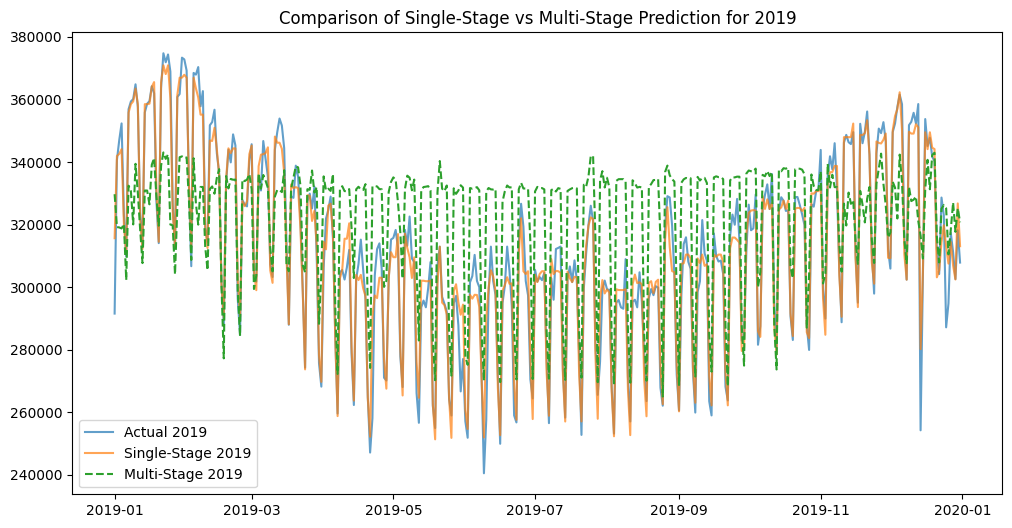

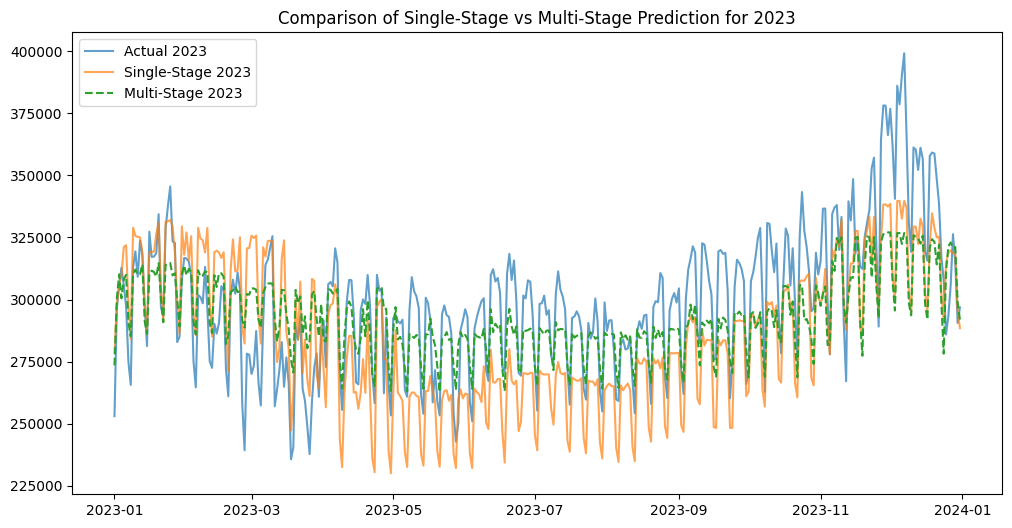

In [91]:
plt.figure(figsize=(12,6))
plt.plot(y_test_single_2019.index, y_test_single_2019, label="Actual 2019", alpha=0.7)
plt.plot(y_test_single_2019.index, y_pred_single_2019, label="Single-Stage 2019", alpha=0.7)
plt.plot(y_test_2019.index, y_pred_2019, label="Multi-Stage 2019", linestyle="dashed")
plt.legend()
plt.title("Comparison of Single-Stage vs Multi-Stage Prediction for 2019")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_single_2023.index, y_test_single_2023, label="Actual 2023", alpha=0.7)
plt.plot(y_test_single_2023.index, y_pred_single_2023, label="Single-Stage 2023", alpha=0.7)
plt.plot(y_test_2023.index, y_pred_2023, label="Multi-Stage 2023", linestyle="dashed")
plt.legend()
plt.title("Comparison of Single-Stage vs Multi-Stage Prediction for 2023")
plt.show()


In [99]:
daily_data.columns

Index(['loadConsumption', 'DailyPrecipitation', 'MaxHourlyPrecipitation',
       'HDMaxPrecipitation', 'DailyMeanTemperature', 'HourlyMinTemperature',
       'HDMinTemperature', 'HourlyMaxTemperature', 'HDMaxTemperature',
       'DailyMeanWindspeed', 'MaxHourlyMeanWindspeed', 'HDMaxMeanWindspeed',
       'MinHourlyMeanWindspeed', 'HDMinMeanWindspeed', 'Month', 'Year', 'Week',
       'WeekKey', 'Predicted_Monthly_Load', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

Epoch 1/50
163/163 [==============================] - 9s 36ms/step - loss: 0.4697 - val_loss: 0.4794
Epoch 2/50
163/163 [==============================] - 6s 34ms/step - loss: 0.2350 - val_loss: 0.2761
Epoch 3/50
163/163 [==============================] - 7s 43ms/step - loss: 0.1718 - val_loss: 0.2425
Epoch 4/50
163/163 [==============================] - 6s 38ms/step - loss: 0.1497 - val_loss: 0.2187
Epoch 5/50
163/163 [==============================] - 6s 40ms/step - loss: 0.1296 - val_loss: 0.2288
Epoch 6/50
163/163 [==============================] - 5s 32ms/step - loss: 0.1190 - val_loss: 0.1928
Epoch 7/50
163/163 [==============================] - 5s 33ms/step - loss: 0.1162 - val_loss: 0.1886
Epoch 8/50
163/163 [==============================] - 5s 30ms/step - loss: 0.1116 - val_loss: 0.1959
Epoch 9/50
163/163 [==============================] - 5s 30ms/step - loss: 0.1057 - val_loss: 0.1904
Epoch 10/50
163/163 [==============================] - 5s 32ms/step - loss: 0.1011 - val_lo

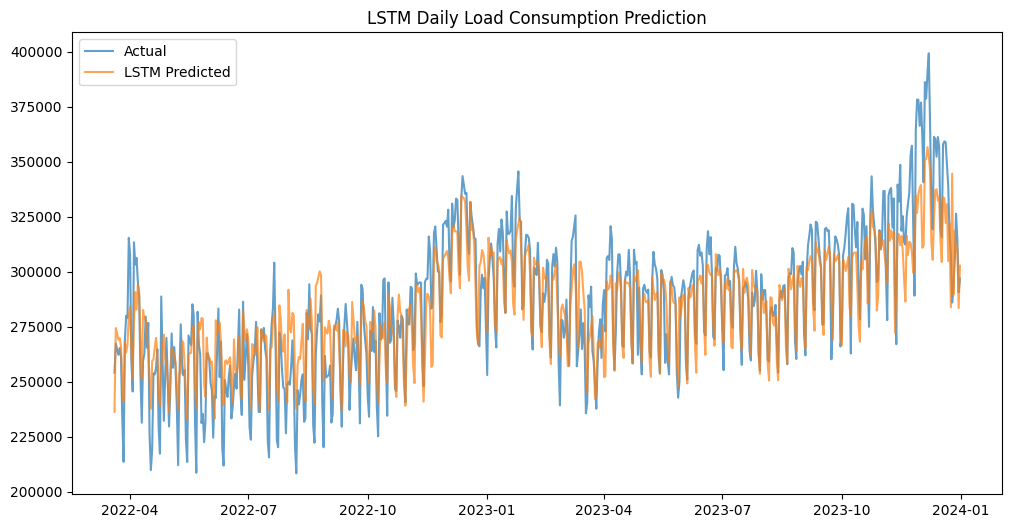

In [102]:
# Define LSTM Data Preparation Function
def prepare_lstm_data(data, target_column, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i-lookback:i].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

# Select Features and Target
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"

# Scale features
scaler_features = StandardScaler()
daily_features_scaled = scaler_features.fit_transform(daily_features)

# Scale target separately
scaler_target = StandardScaler()
daily_target_scaled = scaler_target.fit_transform(daily_data[["loadConsumption"]])

# Combine features and target into a DataFrame
daily_scaled_df = pd.DataFrame(daily_features_scaled, index=daily_data.index, columns=daily_features.columns)
daily_scaled_df["loadConsumption"] = daily_target_scaled  # Add target back

# Prepare LSTM Data
lookback = 30  # Use past 30 days to predict next day
X_lstm, y_lstm = prepare_lstm_data(daily_scaled_df, "loadConsumption", lookback)

# Split Data into Train and Test
split_index = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

# Define LSTM Model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, X_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile Model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train Model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test_lstm))

# Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Rescale Predictions
y_pred_lstm = scaler_target.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_test_lstm = scaler_target.inverse_transform(y_test_lstm.reshape(-1, 1))

# Evaluate Model
print("LSTM Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_lstm, y_pred_lstm)}, MSE: {mean_squared_error(y_test_lstm, y_pred_lstm)}, R^2: {r2_score(y_test_lstm, y_pred_lstm)}, MAPE: {np.mean(np.abs((y_test_lstm - y_pred_lstm) / y_test_lstm)) * 100}")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(daily_data.index[-len(y_test_lstm):], y_test_lstm, label="Actual", alpha=0.7)
plt.plot(daily_data.index[-len(y_test_lstm):], y_pred_lstm, label="LSTM Predicted", alpha=0.7)
plt.legend()
plt.title("LSTM Daily Load Consumption Prediction")
plt.show()


Epoch 1/50
163/163 [==============================] - 9s 42ms/step - loss: 0.6034 - val_loss: 0.7443
Epoch 2/50
163/163 [==============================] - 9s 52ms/step - loss: 0.4786 - val_loss: 0.7238
Epoch 3/50
163/163 [==============================] - 9s 52ms/step - loss: 0.4287 - val_loss: 0.5531
Epoch 4/50
163/163 [==============================] - 7s 45ms/step - loss: 0.3078 - val_loss: 0.3558
Epoch 5/50
163/163 [==============================] - 7s 45ms/step - loss: 0.2249 - val_loss: 0.3602
Epoch 6/50
163/163 [==============================] - 7s 46ms/step - loss: 0.1832 - val_loss: 0.3054
Epoch 7/50
163/163 [==============================] - 7s 44ms/step - loss: 0.1653 - val_loss: 0.2942
Epoch 8/50
163/163 [==============================] - 9s 54ms/step - loss: 0.1429 - val_loss: 0.2703
Epoch 9/50
163/163 [==============================] - 8s 52ms/step - loss: 0.1389 - val_loss: 0.2359
Epoch 10/50
163/163 [==============================] - 7s 45ms/step - loss: 0.1277 - val_lo

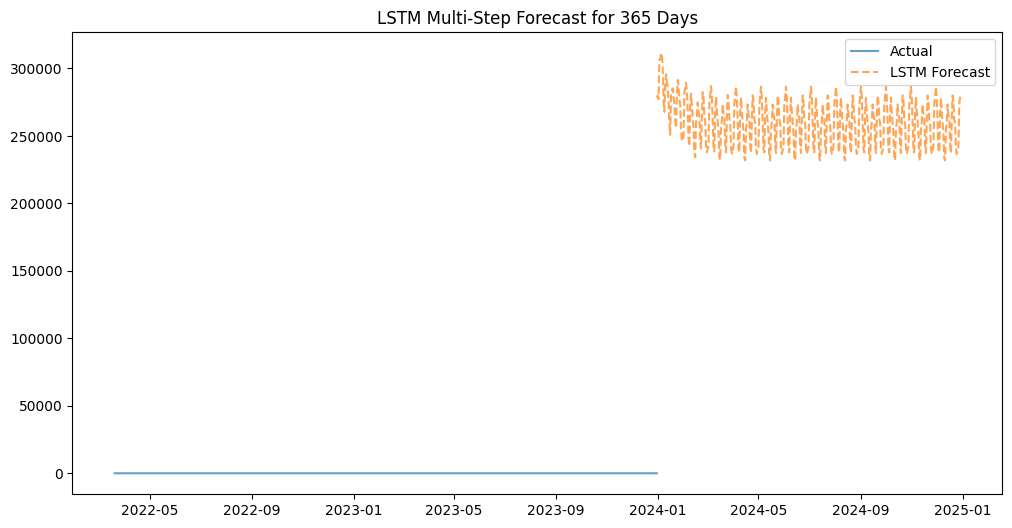

In [103]:
# Define LSTM Data Preparation Function
def prepare_lstm_data(data, target_column, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i-lookback:i].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

# Select Features and Target
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"

# Scale features
scaler_features = StandardScaler()
daily_features_scaled = scaler_features.fit_transform(daily_features)

# Scale target separately
scaler_target = StandardScaler()
daily_target_scaled = scaler_target.fit_transform(daily_data[["loadConsumption"]])

# Combine features and target into a DataFrame
daily_scaled_df = pd.DataFrame(daily_features_scaled, index=daily_data.index, columns=daily_features.columns)
daily_scaled_df["loadConsumption"] = daily_target_scaled  # Add target back

# Prepare LSTM Data
lookback = 30  # Use past 30 days to predict next day
X_lstm, y_lstm = prepare_lstm_data(daily_scaled_df, "loadConsumption", lookback)

# Split Data into Train and Test
split_index = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

# Define LSTM Model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, X_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile Model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train Model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test_lstm))

# Function for Multi-Step Forecasting
def multi_step_forecast(model, initial_input, days_ahead, scaler):
    forecast = []
    current_input = initial_input.copy()
    
    for _ in range(days_ahead):
        pred = model.predict(current_input.reshape(1, current_input.shape[0], current_input.shape[1]))
        forecast.append(pred[0][0])
        
        # Shift input window and add prediction
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, -1] = pred[0][0]  # Use the predicted value
    
    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Predict Next 365 Days Using Multi-Step Forecasting
initial_input = X_test_lstm[-1]  # Start from last known test sample
future_predictions = multi_step_forecast(model_lstm, initial_input, 365, scaler_target)

# Visualization of Future Predictions
dates_future = pd.date_range(start=daily_data.index[-1], periods=365, freq='D')
plt.figure(figsize=(12,6))
plt.plot(daily_data.index[-len(y_test_lstm):], y_test_lstm, label="Actual", alpha=0.7)
plt.plot(dates_future, future_predictions, label="LSTM Forecast", alpha=0.7, linestyle='dashed')
plt.legend()
plt.title("LSTM Multi-Step Forecast for 365 Days")
plt.show()